**Necessary Libraries Import**

In [1]:
!pip install scikeras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score,train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from scikeras.wrappers import KerasRegressor
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_selection import mutual_info_regression

## Data Import

In [3]:
gas_tur = pd.read_csv("gas_turbines.csv")
gas_tur.head(3)

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   

       CO     NOX  
0  3.1547  82.722  
1  3.2363  82.776  
2  3.2012  82.468

In [4]:
gas_tur.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

In [5]:
gas_tur.shape

(15039, 11)

## Data Exploration

+ Overall Description of Data

In [6]:
gas_tur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


+ Missing Data

In [7]:
gas_tur.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

+ Duplicate Data

In [8]:
gas_tur[gas_tur.duplicated()]

Empty DataFrame
Columns: [AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX]
Index: []

### From the Data exploration it can be concluded that
+ There is no missing value in the Data set
+ There are no duplicated values in the Data set

## Data Visualization

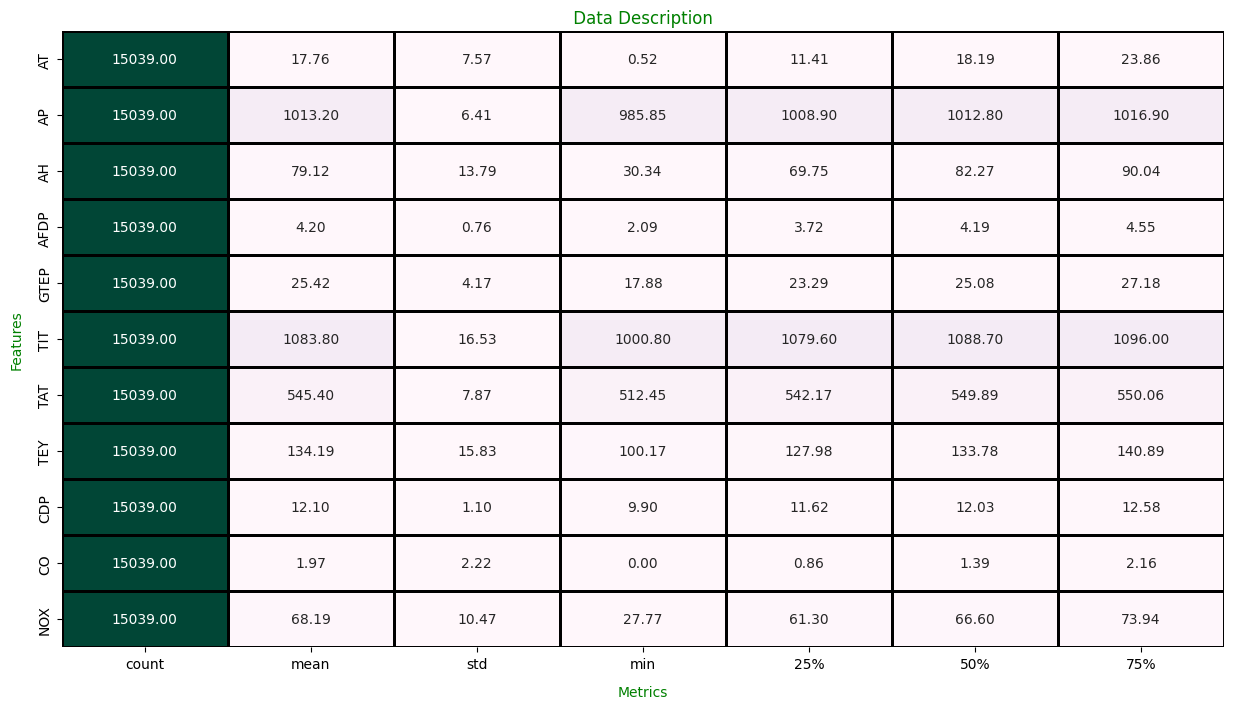

In [9]:
report = gas_tur.describe().T
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(15, 8))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="PuBuGn", fmt=".2f", linewidths=1, linecolor="black",cbar=False)
plt.title(' Data Description ', color='Green')
plt.xlabel('Metrics',labelpad=10,color='Green')
plt.ylabel('Features',labelpad=10, color='Green')
plt.show()

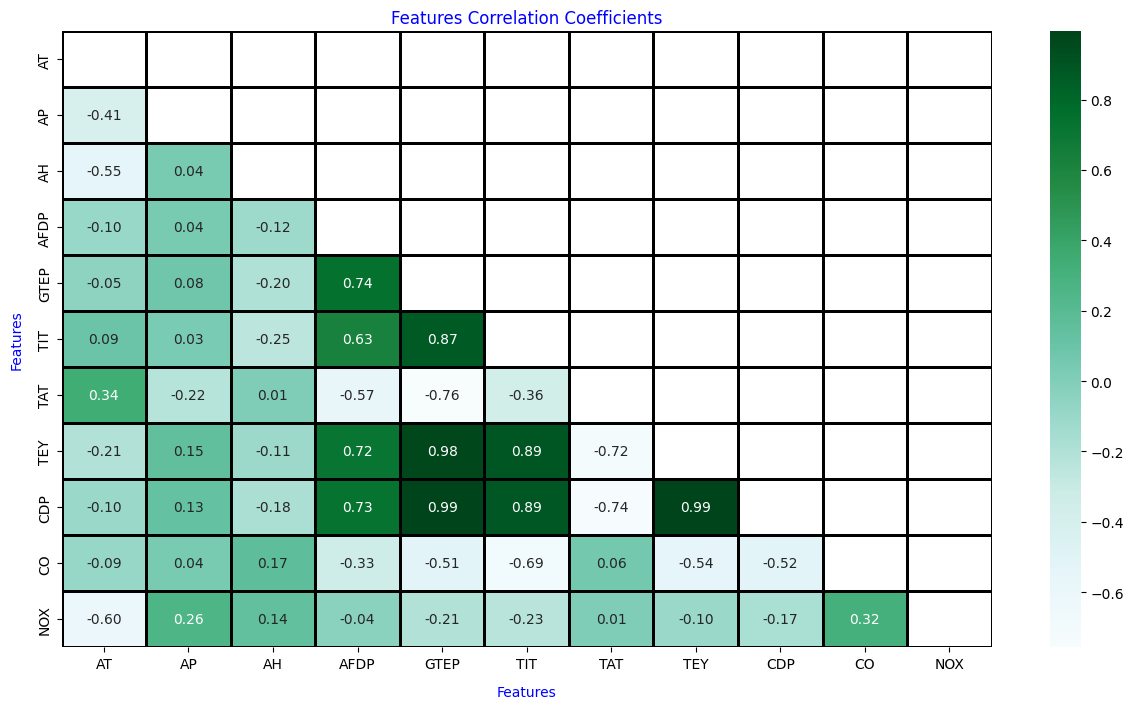

In [11]:
report = gas_tur.corr().T
mask = np.triu(np.ones_like(report, dtype=bool)) # Shows only the Upper Traiangle

plt.figure(figsize=(15, 8))
sns.heatmap(report, mask=mask, annot=True, cmap="BuGn", fmt=".2f", linewidths=1, linecolor="black", cbar=True)
plt.title('Features Correlation Coefficients', color='Blue')
plt.xlabel('Features', labelpad=10, color='Blue')
plt.ylabel('Features', labelpad=10, color='Blue')
plt.show()

## Univariate Analysis for all the variables (Numeric)

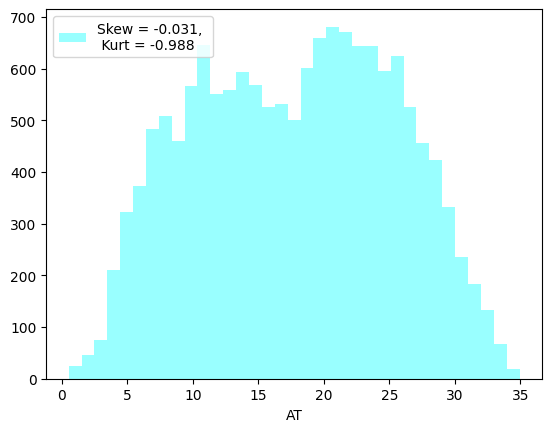

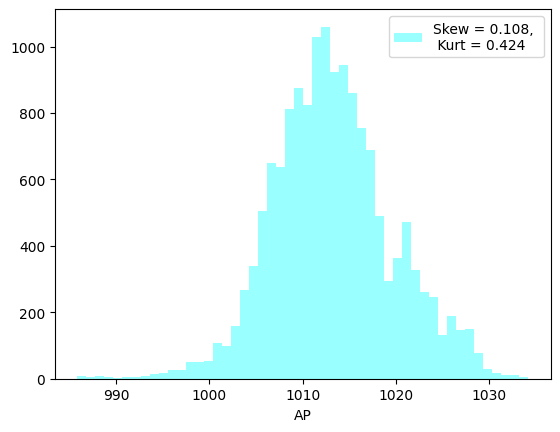

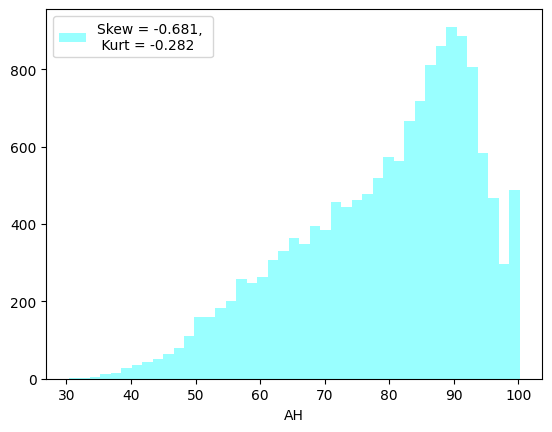

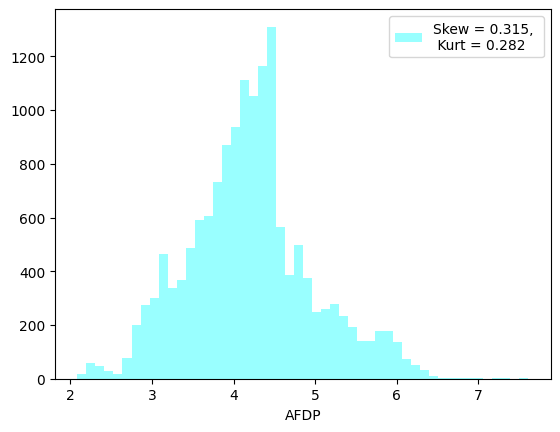

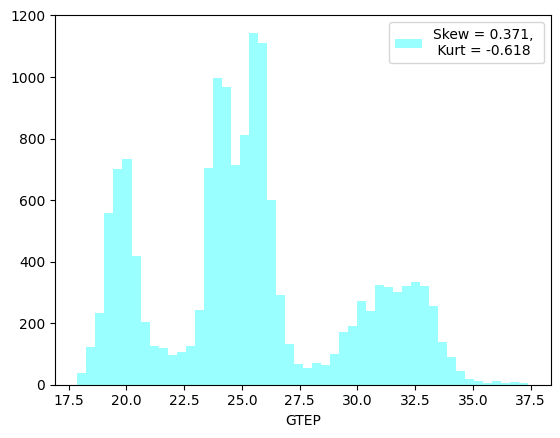

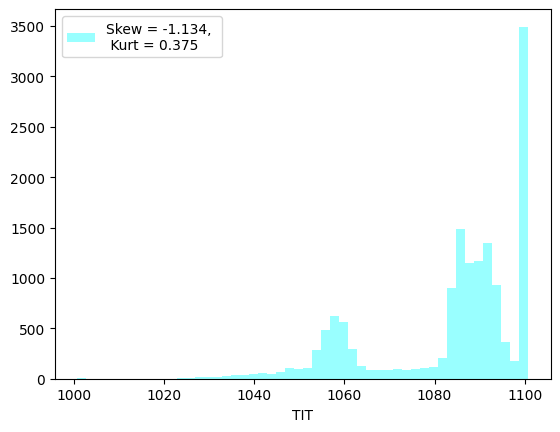

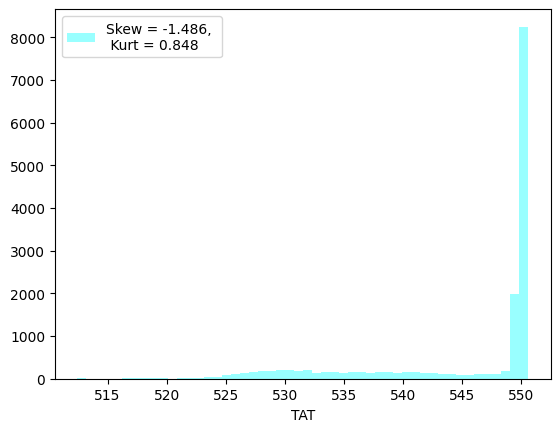

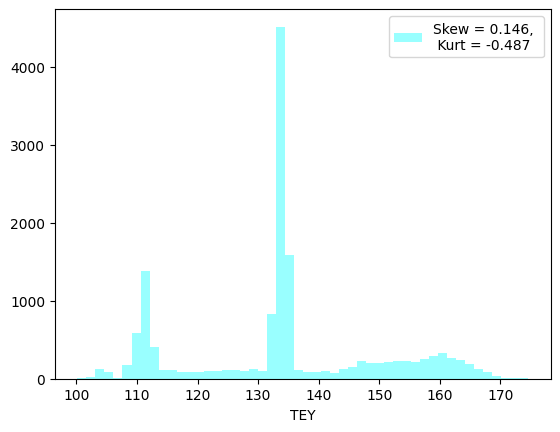

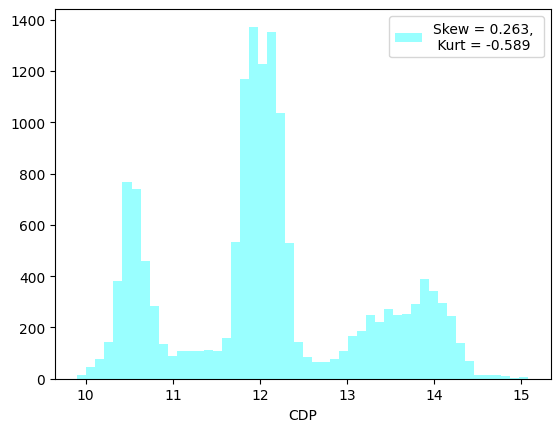

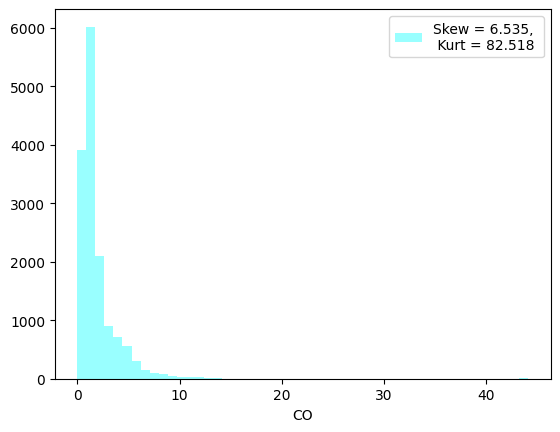

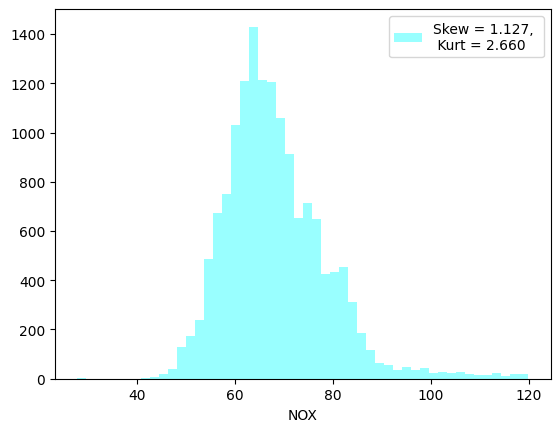

In [12]:
for feature in gas_tur.columns:
  skewness = gas_tur[feature].skew()
  kurtosis = gas_tur[feature].kurt()
  sns.distplot(gas_tur[feature],kde=False, color='cyan',label="Skew = %.3f, \n Kurt = %.3f"%(skewness,kurtosis))
  plt.legend(loc='best')
  plt.show()

## As we can see that Some of the Features are normally Distributed. However, Features like :-
+ TIT
+ TAT
+ NOx

are skewed hower the feature
+ CO

is skewed as well has very high value of kurtosis

## Now let's check the presence of outliers - using Turkey's Method

In [13]:
from collections import Counter

In [14]:
def detect_outliers(df):
  "This function is expected to take a dataframe as input and return a list of indices of the observations which contain more than 2 outliers"
  out_ind = []

  for col in df.columns.tolist():

    # First Quartile (25%)
    Q1 = np.percentile(df[col],25)

    # Third Quartile (75%)
    Q3 = np.percentile(df[col],75)

    # Interquatile Range (IQR)
    IQR = Q1-Q3

    # IQR Multiplier
    Multiplier = 1.5*IQR

    # List of indices for the outliers
    outlier_lndex_list = df[(df[col] < Q1-Multiplier) | (df[col] > Q3 + Multiplier)].index

    # Extend the outlier index list
    out_ind.extend(outlier_lndex_list)
  # select observations containing more than 2 outliers
  out_ind = Counter(out_ind)
  multiple_outliers = list( k for k, v in out_ind.items() if v > 2 )
  return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(detect_outliers(gas_tur))))

The dataset contains 15039 observations with more than 2 outliers


## We can see that ther are many outliers in the Data let's Draw the box plot in order to visualize it

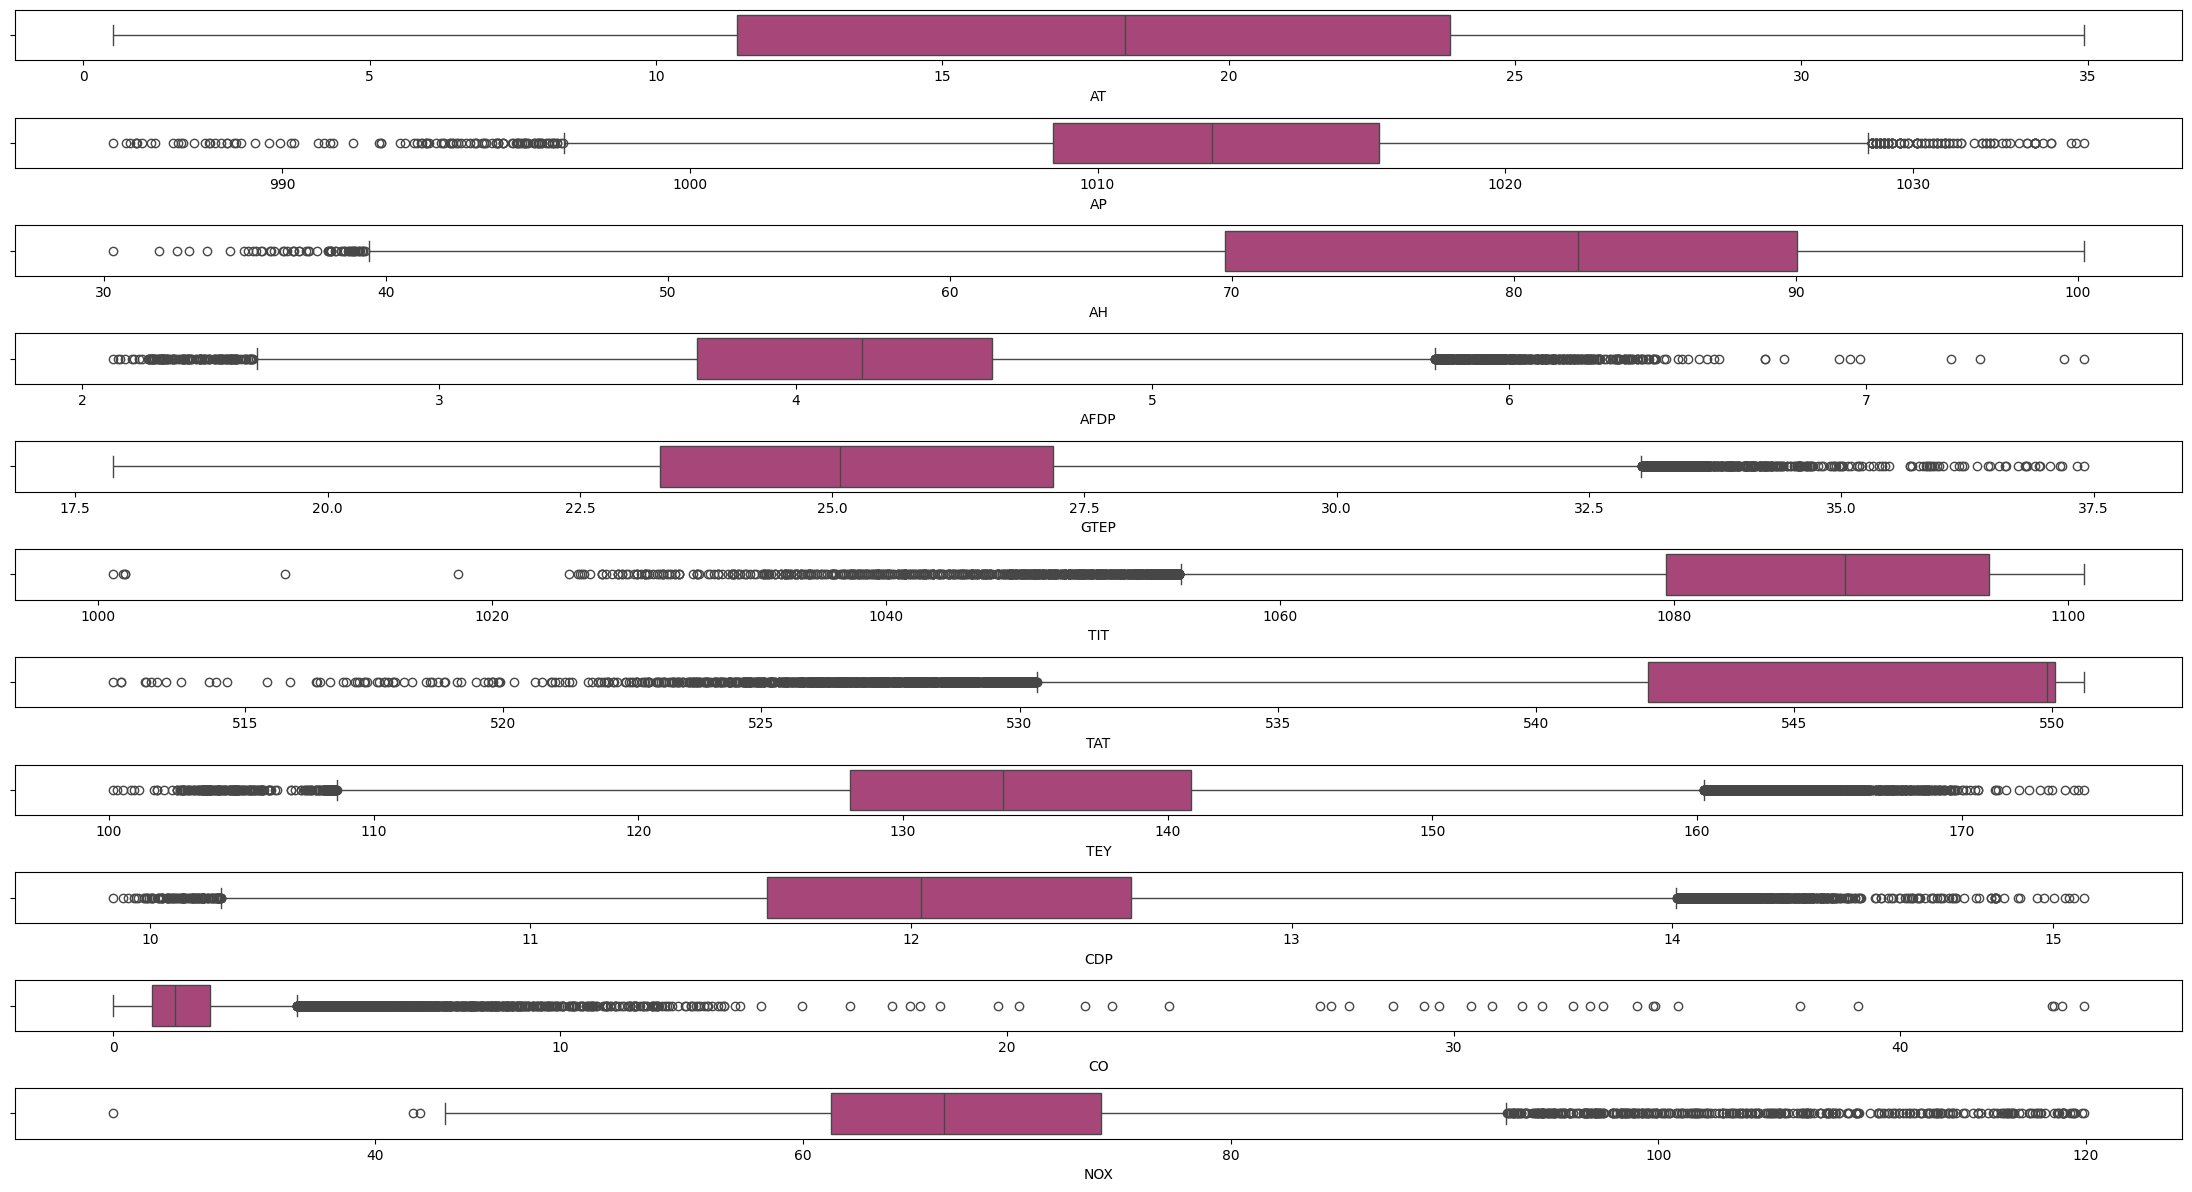

In [15]:
outlier_data = gas_tur.copy()
fig, axes=plt.subplots(len(outlier_data.columns.to_list()),1,figsize=(22,12),sharex=False,sharey=False)
for i in range(len(outlier_data.columns.to_list())):
  sns.boxplot(x=outlier_data.iloc[:,i],palette='magma',data=outlier_data,ax=axes[i])
plt.tight_layout(pad=1.0)

<Axes: >

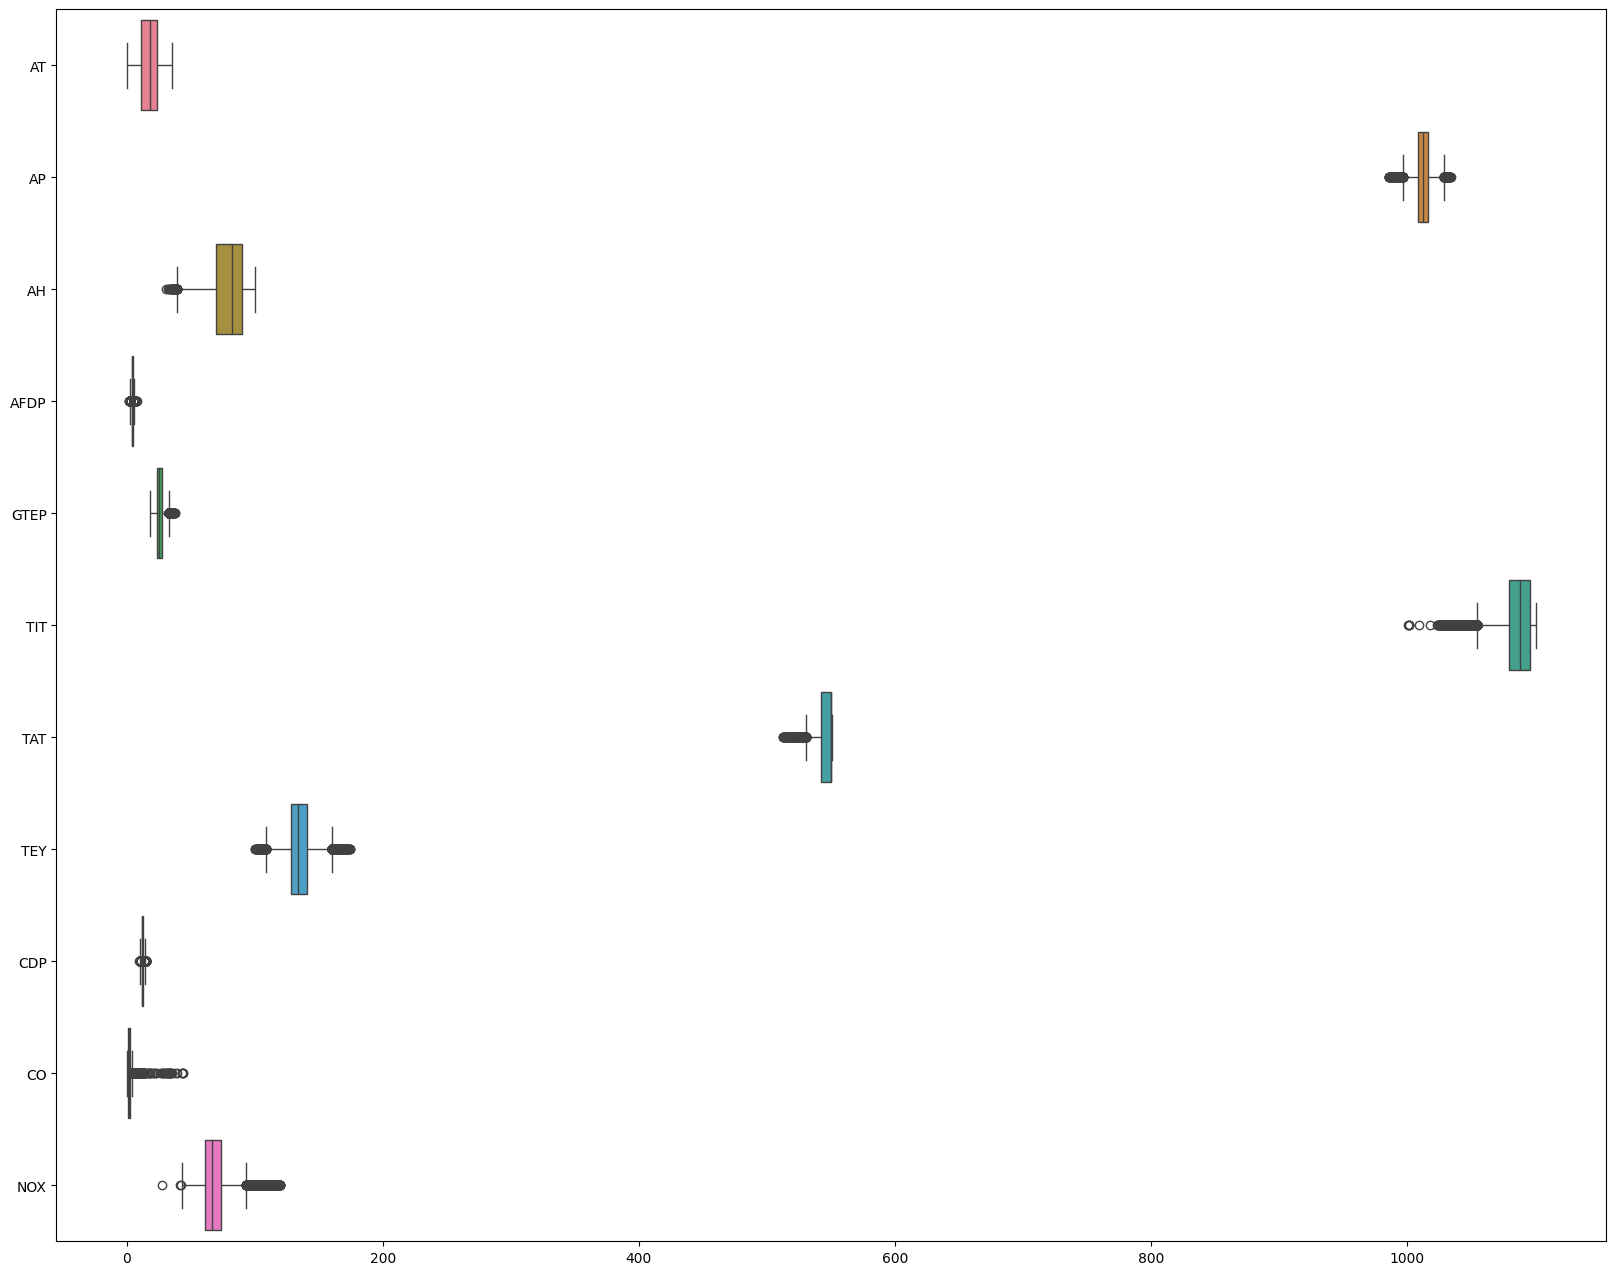

In [16]:
#outlier
plt.figure(figsize=(20,16))
sns.boxplot(data=outlier_data, orient="h")

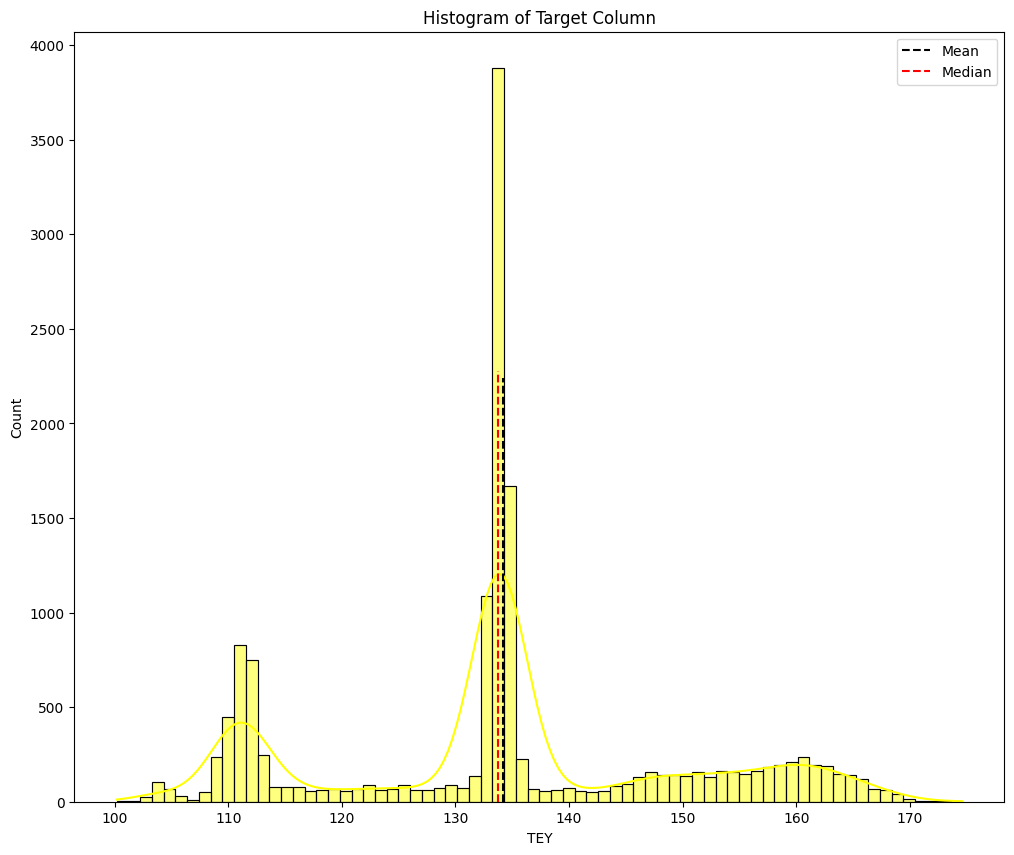

In [17]:
plt.figure(figsize=(12,10))
sns.histplot(data=gas_tur,x="TEY",color="yellow",kde=True)
plt.axvline(x=gas_tur["TEY"].mean(),ymax=0.55,color="black",linestyle='--',label="Mean")
plt.axvline(x=gas_tur["TEY"].median(),ymax=0.56,color="red",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of Target Column")
plt.show()

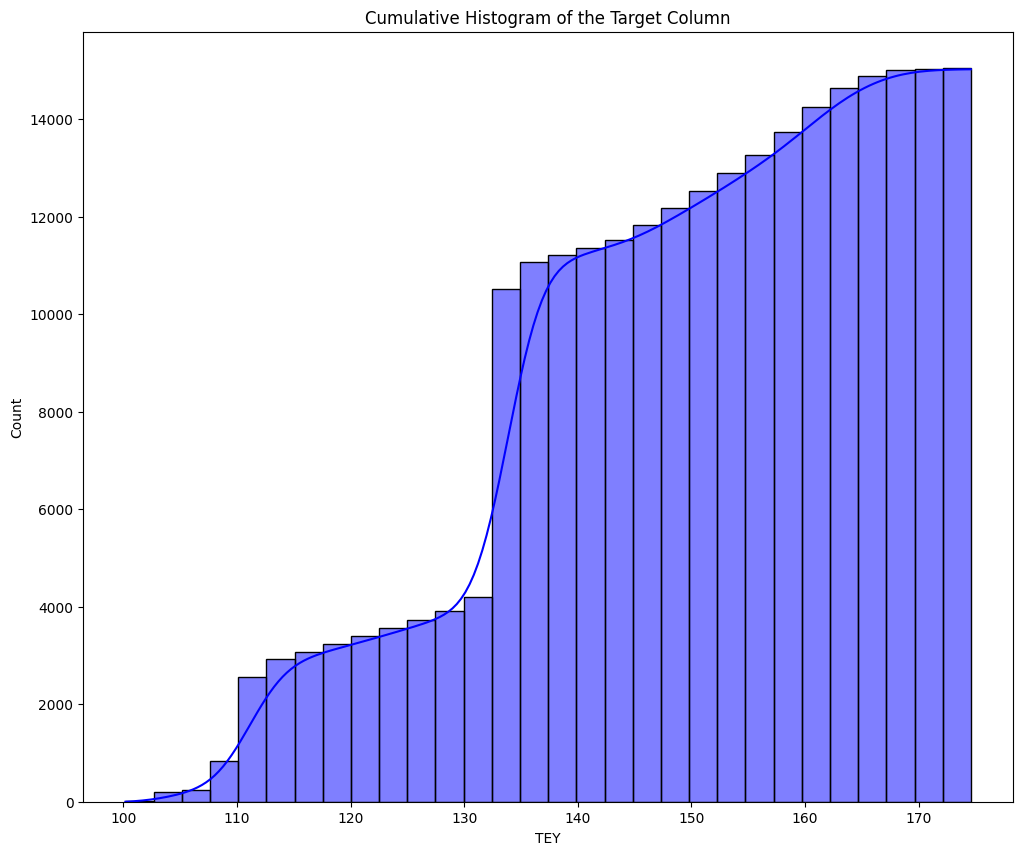

In [18]:
plt.figure(figsize = (12,10))
sns.histplot(gas_tur["TEY"],kde=True,bins=30,color="blue",cumulative=True)
plt.title("Cumulative Histogram of the Target Column")
plt.show()

## As we have already seen none of the features are on the same scale

## Multivariate Analysis :- Now we visually the variation of Target Variable 'TEY' w.r.t all other variables

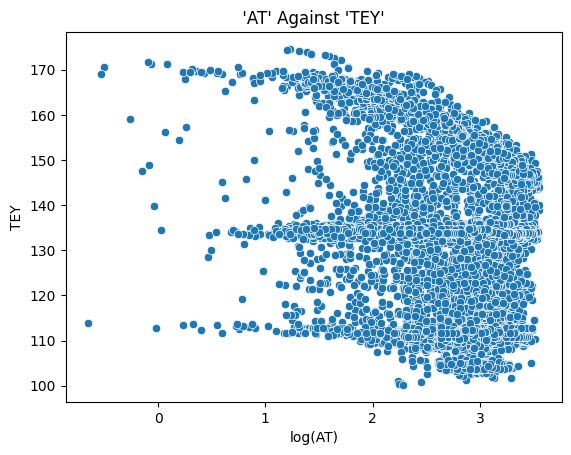

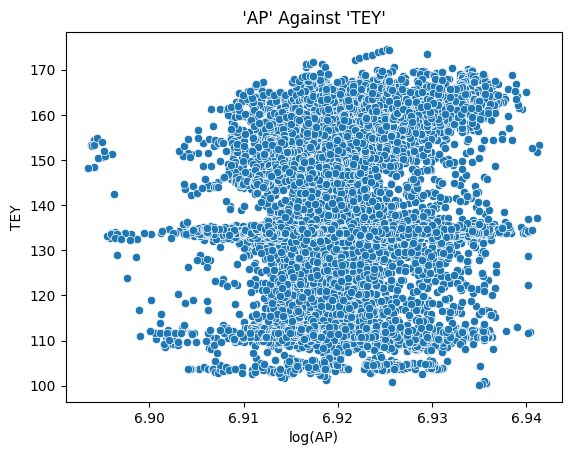

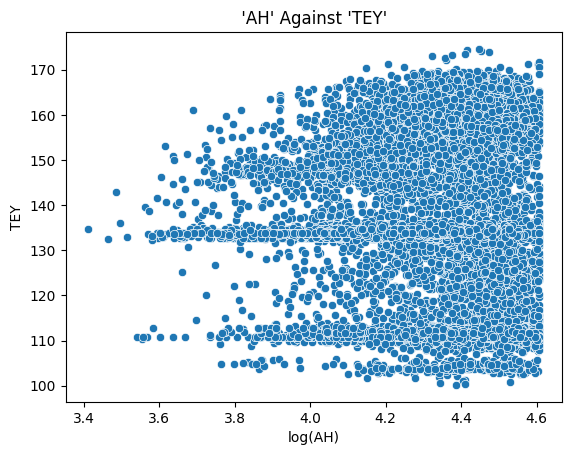

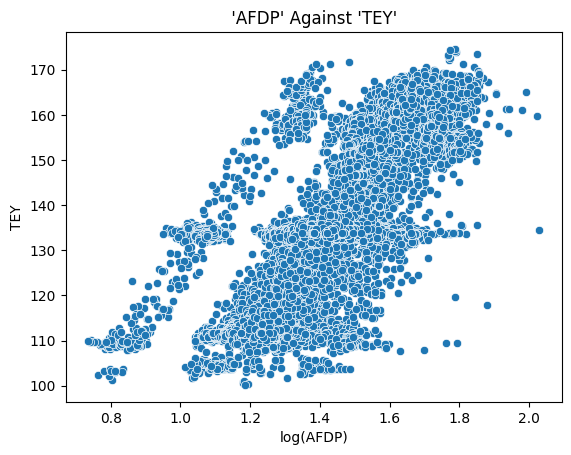

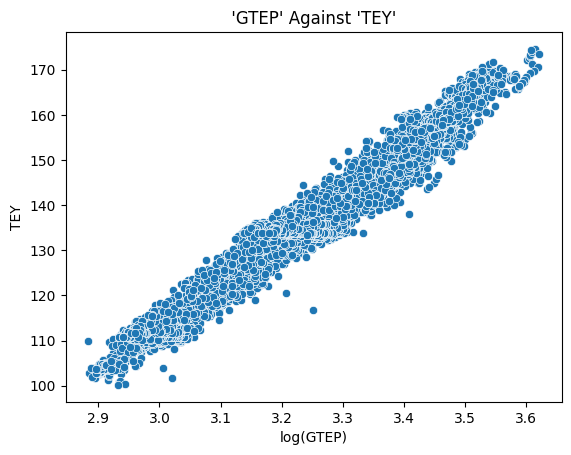

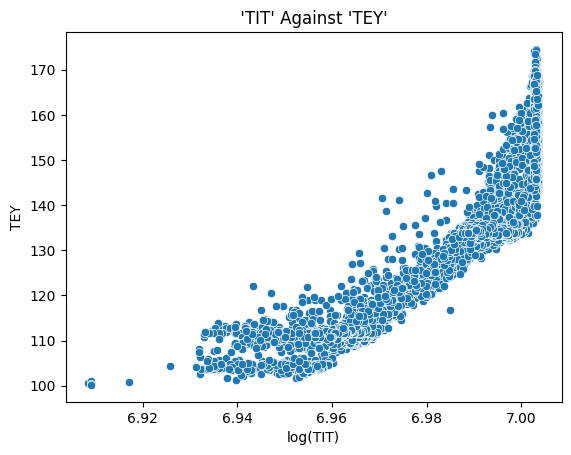

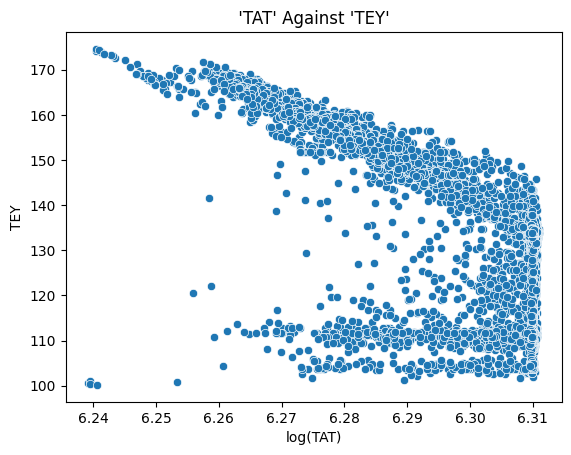

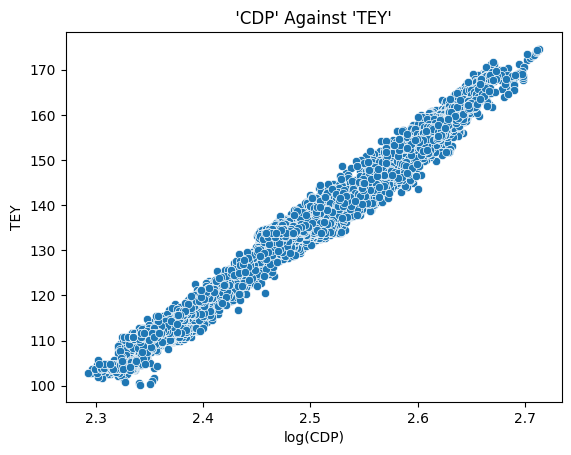

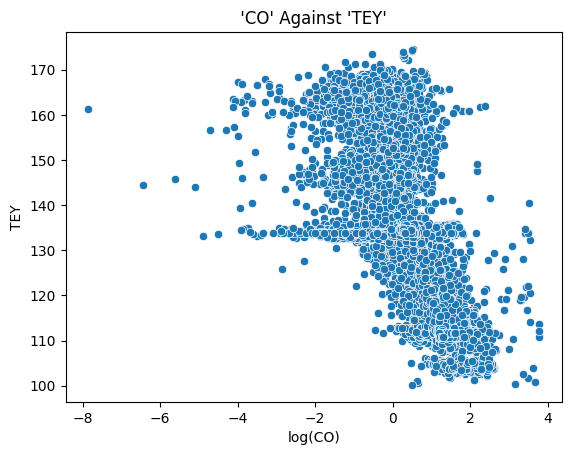

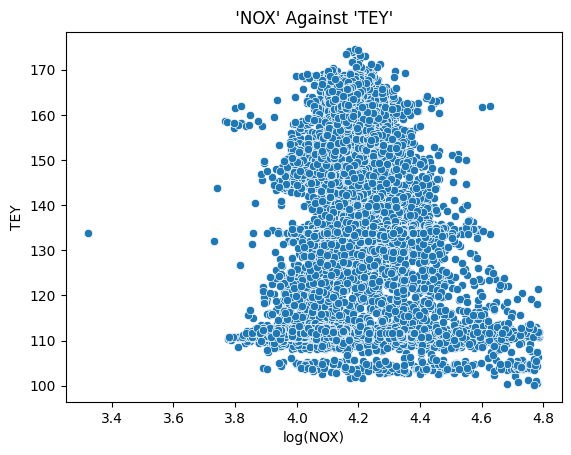

In [19]:
for col in gas_tur.columns.to_list() :
  if col != 'TEY':
    sns.scatterplot(x = np.log(gas_tur[col]),y=gas_tur["TEY"],data=gas_tur)
    plt.title(f" '{col}' Against 'TEY' ")
    plt.xlabel(f"log({col})")
    plt.show()

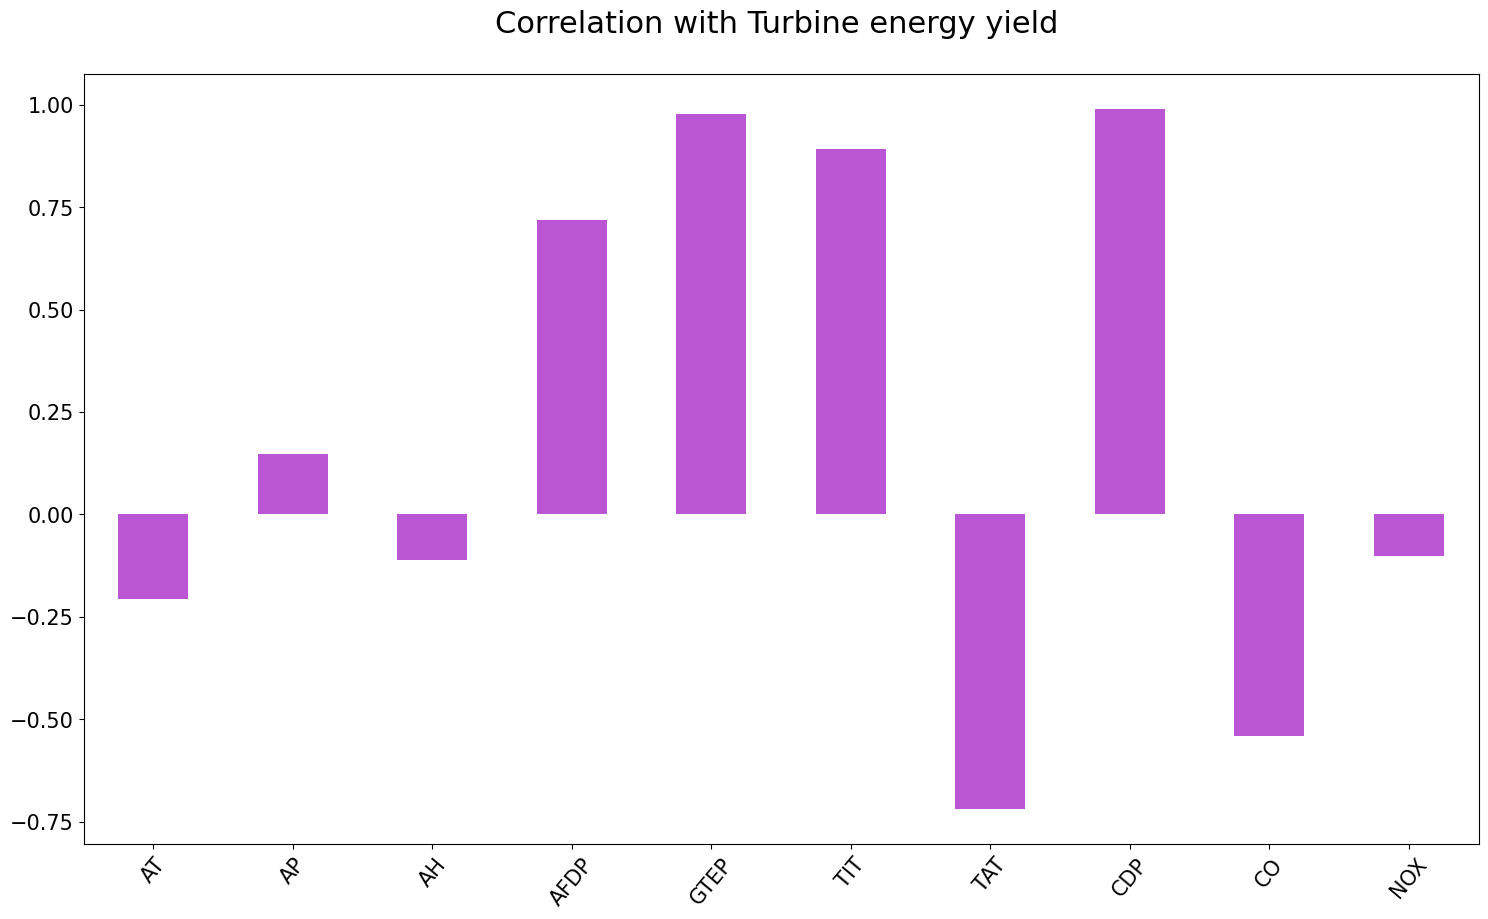

In [23]:
data = gas_tur.copy()

correlations = data.corrwith(data.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10),
        fontsize = 15,
        color = '#ba55d3',
        rot=50,
        grid = False)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal",
fontsize = "22")
plt.show()

<Figure size 2000x2000 with 0 Axes>

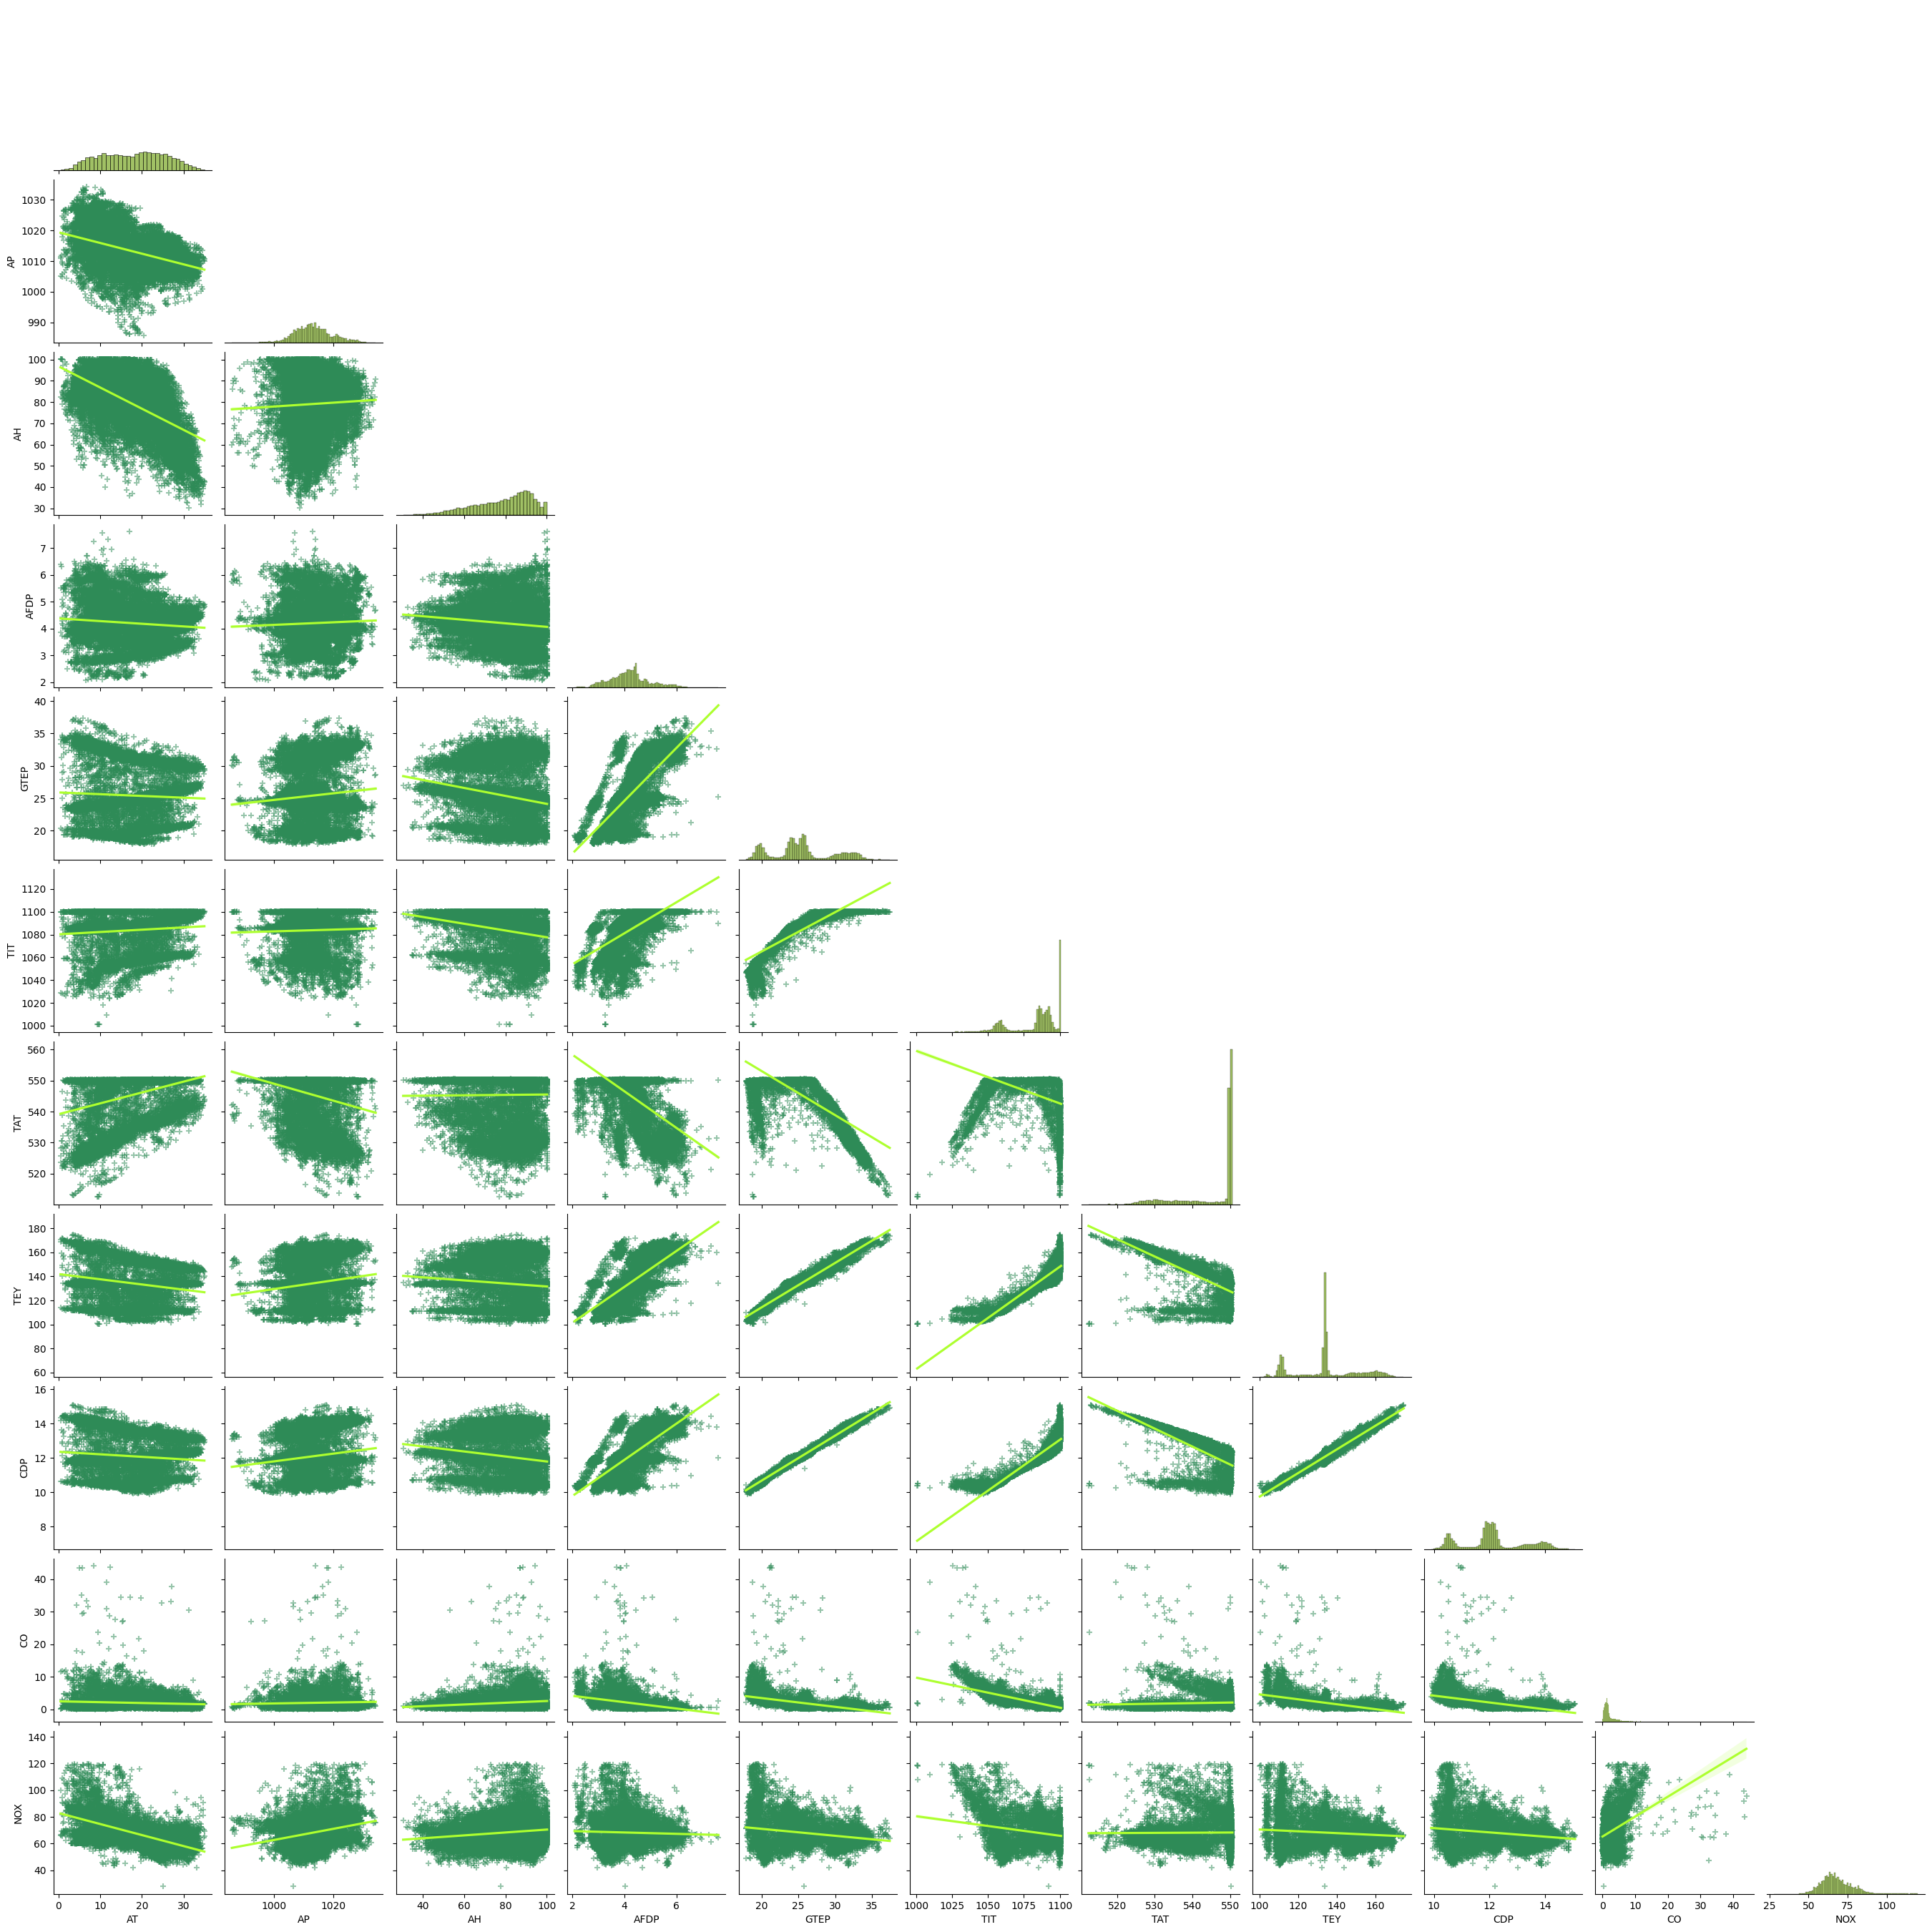

In [26]:
plt.figure(figsize=(20,20))
sns.pairplot(gas_tur,
                 markers="+",
                 kind='reg',
                 diag_kind="hist",
                 plot_kws={'line_kws':{'color':'#adff2f'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#2e8b57'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})
plt.show()

In [27]:
x = gas_tur.drop('TEY',axis=1)
y = gas_tur['TEY']

In [28]:
print(x.head(3),'\n\n')
print(y.head(3))

       AT      AP      AH    AFDP    GTEP     TIT     TAT     CDP      CO  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  10.605  3.1547   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  10.598  3.2363   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  10.601  3.2012   

      NOX  
0  82.722  
1  82.776  
2  82.468   


0    114.70
1    114.72
2    114.71
Name: TEY, dtype: float64


# Feature Selection - using K-Best Features

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [30]:
test = SelectKBest(score_func =mutual_info_regression,k='all') # Final selection will be based on this value only
fit_func = test.fit(x,y)

In [31]:
score = fit_func.scores_
feat_final = fit_func.transform(x)

In [32]:
score_df = pd.DataFrame(list(zip(score,x.columns)),
                                   columns = ['Score','Feature'])
score_df.sort_values(by="Score", ascending=False,inplace=True)
score_df

Score Feature
7  1.713157     CDP
4  1.599921    GTEP
5  1.324774     TIT
6  0.895129     TAT
3  0.661156    AFDP
8  0.513278      CO
0  0.412510      AT
9  0.300458     NOX
1  0.137753      AP
2  0.097854      AH

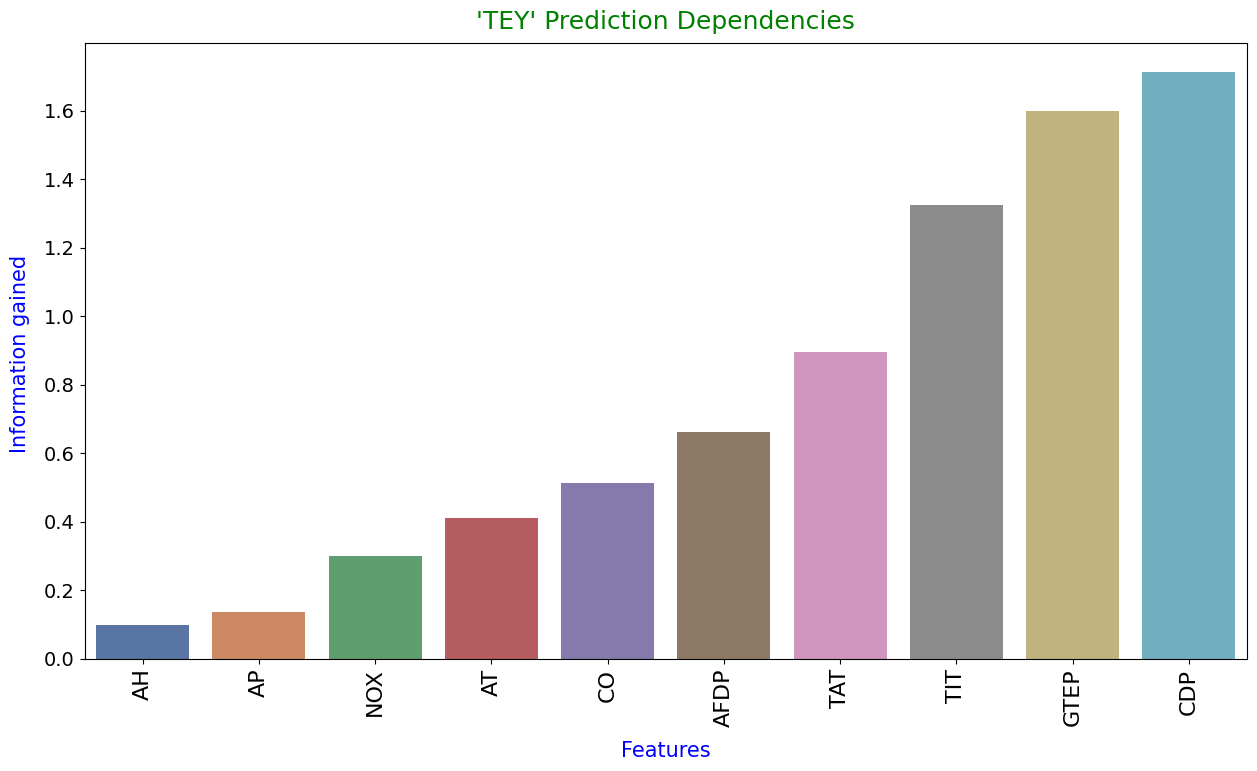

In [33]:
plt.figure(figsize=(15,8))
sns.barplot(x='Feature', y = 'Score', data=score_df,
            order=score_df.sort_values('Score').Feature,
            palette='deep')
            #order=score_df.Score.sort_values())
plt.xlabel('Features',fontsize=15,labelpad=10,color='Blue')
plt.ylabel('Information gained ',fontsize=15,labelpad=10,color='Blue')
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("'TEY' Prediction Dependencies",fontsize=18,pad=10,color='Green')
plt.show()

In [34]:
nn_data = gas_tur[['CDP','GTEP','TIT','TAT','AFDP','CO','AT','TEY']]
nn_data.head()

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0  10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1  10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2  10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3  10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4  10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72

## Data Preprocessing
+ First we scale the data due to variation in values

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tremp_data = pd.DataFrame(scaler.fit_transform(nn_data),columns=nn_data.columns.to_list())
tremp_data.head()

CDP      GTEP       TIT       TAT      AFDP        CO        AT  \
0 -1.357331 -1.379101 -1.488376  0.585240 -0.921232  0.532012 -1.439778   
1 -1.363676 -1.363528 -1.482325  0.585240 -0.921495  0.568733 -1.449601   
2 -1.360957 -1.351309 -1.476275  0.568715 -0.944385  0.552938 -1.434721   
3 -1.356424 -1.348194 -1.464173  0.583969 -0.946884  0.548933 -1.413702   
4 -1.350985 -1.354663 -1.458123  0.582698 -0.924389  0.574179 -1.368693   

        TEY  
0 -1.231172  
1 -1.229909  
2 -1.230541  
3 -1.229909  
4 -1.229909

In [37]:
y = tremp_data.iloc[:,tremp_data.columns.isin(['TEY'])]
x = tremp_data.iloc[:,~tremp_data.columns.isin(['TEY'])]

In [38]:
x.head()

CDP      GTEP       TIT       TAT      AFDP        CO        AT
0 -1.357331 -1.379101 -1.488376  0.585240 -0.921232  0.532012 -1.439778
1 -1.363676 -1.363528 -1.482325  0.585240 -0.921495  0.568733 -1.449601
2 -1.360957 -1.351309 -1.476275  0.568715 -0.944385  0.552938 -1.434721
3 -1.356424 -1.348194 -1.464173  0.583969 -0.946884  0.548933 -1.413702
4 -1.350985 -1.354663 -1.458123  0.582698 -0.924389  0.574179 -1.368693

In [39]:
y.head()

TEY
0 -1.231172
1 -1.229909
2 -1.230541
3 -1.229909
4 -1.229909

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2, random_state=42)

# Hyperparameter Tuning :-
1. Optimal Learning rate ,Number of Layers and Neurons

In [ ]:
def build_model(hypt):
  model = Sequential()
  for i in range(hypt.Int('num_layers',2,20)):
    model.add(layers.Dense(units=hypt.))

In [43]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [44]:
from kerastuner import RandomSearch

In [45]:
def build_model(hp):
    model =Sequential()                                                                           #  Initializes a Sequential model i.e. linear stack of layers.
    for i in range(hp.Int('num_layers', 2, 20)):                                                  #  Determine the number of layers in the model.
        model.add(layers.Dense(units=hp.Int('units_' + str(i),                                    #  adds a dense (fully connected) layer to the model. activation function used in this layer is ReLU.
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))                                              #  This layer is typically used for regression tasks where the model predicts a continuous value.
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),                                     # Configures the model for training by specifying the optimizer, loss function, and metrics to monitor during training.
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [46]:
tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=5,
                     executions_per_trial=3,directory='project',project_name='Gas Turbine')     # The RandomSearch tuner will search the hyperparameter space defined in build_model to find the best model configuration based on the specified objective.

In [47]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
tuner.search(X_train, Y_train,epochs=100,validation_data=(X_test, Y_test))

Trial 5 Complete [00h 09m 42s]
val_mean_absolute_error: 0.02258700629075368

Best val_mean_absolute_error So Far: 0.02258700629075368
Total elapsed time: 00h 44m 40s


In [50]:
tuner.results_summary()

Results summary
Results in project/Gas Turbine
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 4 summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 64
learning_rate: 0.001
units_2: 96
units_3: 32
units_4: 64
units_5: 32
units_6: 32
units_7: 96
units_8: 96
units_9: 64
units_10: 64
units_11: 32
units_12: 96
units_13: 64
units_14: 96
Score: 0.02258700629075368

Trial 3 summary
Hyperparameters:
num_layers: 12
units_0: 64
units_1: 32
learning_rate: 0.001
units_2: 64
units_3: 32
units_4: 64
units_5: 96
units_6: 32
units_7: 32
units_8: 32
units_9: 96
units_10: 32
units_11: 64
units_12: 32
units_13: 96
units_14: 32
Score: 0.022992756838599842

Trial 0 summary
Hyperparameters:
num_layers: 15
units_0: 96
units_1: 64
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
Score: 0.02303772233426571

Trial 1 summary
Hyperp

## Hyperparameter Tuning:
2. Optimal Batch_size, Number of Epochs

In [52]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))

    adam=Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [53]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [55]:
grid_result = grid.fit(X_test,Y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ....batch_size=10, epochs=10;, score=0.996 total time=  12.6s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ....batch_size=10, epochs=10;, score=0.992 total time=  10.2s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ....batch_size=10, epochs=10;, score=0.996 total time=  12.9s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ....batch_size=10, epochs=10;, score=0.992 total time=  10.3s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ....batch_size=10, epochs=10;, score=0.998 total time=  12.9s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ....batch_size=10, epochs=50;

In [57]:
print('Best Score {}, obtained using following parameters {}'.format(np.round(grid_result.best_score_,3),grid_result.best_params_,3))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("Mean = {}, Standard Deviation = {} with following Parameters {}".format(np.round(mean,3),np.round(stdev,3),param,3))

Best Score 0.998, obtained using following parameters {'batch_size': 20, 'epochs': 200}
Mean = 0.995, Standard Deviation = 0.002 with following Parameters {'batch_size': 10, 'epochs': 10}
Mean = 0.997, Standard Deviation = 0.001 with following Parameters {'batch_size': 10, 'epochs': 50}
Mean = 0.998, Standard Deviation = 0.001 with following Parameters {'batch_size': 10, 'epochs': 100}
Mean = 0.998, Standard Deviation = 0.0 with following Parameters {'batch_size': 10, 'epochs': 200}
Mean = 0.997, Standard Deviation = 0.001 with following Parameters {'batch_size': 20, 'epochs': 10}
Mean = 0.997, Standard Deviation = 0.001 with following Parameters {'batch_size': 20, 'epochs': 50}
Mean = 0.997, Standard Deviation = 0.001 with following Parameters {'batch_size': 20, 'epochs': 100}
Mean = 0.998, Standard Deviation = 0.0 with following Parameters {'batch_size': 20, 'epochs': 200}
Mean = 0.997, Standard Deviation = 0.001 with following Parameters {'batch_size': 40, 'epochs': 10}
Mean = 0.997

## Hyperparameter Tuning:
3. Optimal Droupout rate

In [58]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))

    adam=Adam(lr=0.001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [62]:
model2=KerasRegressor(build_fn=create_model,dropout_rate=0.0,batch_size=40,epochs=200,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [63]:
grid_result2 = grid2.fit(X_test,Y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................


[CV 1/5; 1/6] END .............dropout_rate=0.0;, score=0.998 total time=  44.1s
[CV 2/5; 1/6] START dropout_rate=0.0............................................


[CV 2/5; 1/6] END .............dropout_rate=0.0;, score=0.998 total time=  43.8s
[CV 3/5; 1/6] START dropout_rate=0.0............................................


[CV 3/5; 1/6] END .............dropout_rate=0.0;, score=0.998 total time=  43.9s
[CV 4/5; 1/6] START dropout_rate=0.0............................................


[CV 4/5; 1/6] END .............dropout_rate=0.0;, score=0.997 total time=  39.8s
[CV 5/5; 1/6] START dropout_rate=0.0............................................


[CV 5/5; 1/6] END .............dropout_rate=0.0;, score=0.998 total time=  44.2s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END .............dropout_rate=0.1;, score=0.996 total time=  43.7s
[CV 2/5; 2/6] START dropout_rate=0.1............................................


[CV 2/5; 2/6] END .............dropout_rate=0.1;, score=0.998 total time=  44.1s
[CV 3/5; 2/6] START dropout_rate=0.1............................................


[CV 3/5; 2/6] END .............dropout_rate=0.1;, score=0.995 total time= 1.4min
[CV 4/5; 2/6] START dropout_rate=0.1............................................
[CV 4/5; 2/6] END .............dropout_rate=0.1;, score=0.997 total time=  40.3s
[CV 5/5; 2/6] START dropout_rate=0.1............................................


[CV 5/5; 2/6] END .............dropout_rate=0.1;, score=0.997 total time=  44.3s
[CV 1/5; 3/6] START dropout_rate=0.2............................................


[CV 1/5; 3/6] END .............dropout_rate=0.2;, score=0.998 total time=  43.8s
[CV 2/5; 3/6] START dropout_rate=0.2............................................


[CV 2/5; 3/6] END .............dropout_rate=0.2;, score=0.997 total time=  48.7s
[CV 3/5; 3/6] START dropout_rate=0.2............................................


[CV 3/5; 3/6] END .............dropout_rate=0.2;, score=0.998 total time= 1.4min
[CV 4/5; 3/6] START dropout_rate=0.2............................................


[CV 4/5; 3/6] END .............dropout_rate=0.2;, score=0.996 total time=  43.8s
[CV 5/5; 3/6] START dropout_rate=0.2............................................


[CV 5/5; 3/6] END .............dropout_rate=0.2;, score=0.998 total time=  43.6s
[CV 1/5; 4/6] START dropout_rate=0.3............................................


[CV 1/5; 4/6] END .............dropout_rate=0.3;, score=0.998 total time=  43.6s
[CV 2/5; 4/6] START dropout_rate=0.3............................................
[CV 2/5; 4/6] END .............dropout_rate=0.3;, score=0.998 total time=  43.5s
[CV 3/5; 4/6] START dropout_rate=0.3............................................


[CV 3/5; 4/6] END .............dropout_rate=0.3;, score=0.998 total time=  41.8s
[CV 4/5; 4/6] START dropout_rate=0.3............................................


[CV 4/5; 4/6] END .............dropout_rate=0.3;, score=0.998 total time=  44.1s
[CV 5/5; 4/6] START dropout_rate=0.3............................................
[CV 5/5; 4/6] END .............dropout_rate=0.3;, score=0.998 total time=  43.7s
[CV 1/5; 5/6] START dropout_rate=0.4............................................


[CV 1/5; 5/6] END .............dropout_rate=0.4;, score=0.998 total time=  41.5s
[CV 2/5; 5/6] START dropout_rate=0.4............................................
[CV 2/5; 5/6] END .............dropout_rate=0.4;, score=0.998 total time= 1.4min
[CV 3/5; 5/6] START dropout_rate=0.4............................................


[CV 3/5; 5/6] END .............dropout_rate=0.4;, score=0.997 total time=  43.7s
[CV 4/5; 5/6] START dropout_rate=0.4............................................


[CV 4/5; 5/6] END .............dropout_rate=0.4;, score=0.996 total time=  43.9s
[CV 5/5; 5/6] START dropout_rate=0.4............................................


[CV 5/5; 5/6] END .............dropout_rate=0.4;, score=0.999 total time=  39.8s
[CV 1/5; 6/6] START dropout_rate=0.5............................................
[CV 1/5; 6/6] END .............dropout_rate=0.5;, score=0.999 total time=  39.7s
[CV 2/5; 6/6] START dropout_rate=0.5............................................


[CV 2/5; 6/6] END .............dropout_rate=0.5;, score=0.998 total time=  43.8s
[CV 3/5; 6/6] START dropout_rate=0.5............................................


[CV 3/5; 6/6] END .............dropout_rate=0.5;, score=0.998 total time=  39.5s
[CV 4/5; 6/6] START dropout_rate=0.5............................................
[CV 4/5; 6/6] END .............dropout_rate=0.5;, score=0.997 total time=  40.1s
[CV 5/5; 6/6] START dropout_rate=0.5............................................


[CV 5/5; 6/6] END .............dropout_rate=0.5;, score=0.998 total time=  43.7s


In [66]:
print('Best Score: {}, obtained using Parameter: {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("Mean: {},Standard Deviation: {} with Parameter: {}".format(mean,stdev,param))

Best Score: 0.9981247246018867, obtained using Parameter: {'dropout_rate': 0.3}
Mean: 0.9976619750507556,Standard Deviation: 0.0006502392395014659 with Parameter: {'dropout_rate': 0.0}
Mean: 0.9968013051326864,Standard Deviation: 0.0008688953047052968 with Parameter: {'dropout_rate': 0.1}
Mean: 0.9975519203843468,Standard Deviation: 0.0005939649621520169 with Parameter: {'dropout_rate': 0.2}
Mean: 0.9981247246018867,Standard Deviation: 0.0002231439129213436 with Parameter: {'dropout_rate': 0.3}
Mean: 0.997712444183972,Standard Deviation: 0.0008360354447396936 with Parameter: {'dropout_rate': 0.4}
Mean: 0.9980185605748009,Standard Deviation: 0.00043135751418118515 with Parameter: {'dropout_rate': 0.5}


## Hyperparameter Tuning:
4. Optimal Activation Function and Kernel Initializer

In [92]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))

    adam=Adam(learning_rate=0.001)
    model3.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model3

In [90]:
model = KerasRegressor(build_fn=create_model, verbose=0,activation_function= 'relu',init='uniform')

# Define the grid search parameters
param_grid = {
    'activation_function': ['relu', 'sigmoid'],
    'init': ['uniform', 'normal']
}

# Create and fit the grid search
grid3 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [93]:
grid_result3 = grid3.fit(X_test,Y_test)

In [94]:
print('Best Score: {}, using Paramter {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("Mean: {},Standard Deviation: {} with Parameters: {}".format(mean,stdev,param))

Best Score: 0.3364852483142499, using Paramter {'activation_function': 'sigmoid', 'init': 'normal'}
Mean: 0.3346531937373009,Standard Deviation: 0.09257461718985964 with Parameters: {'activation_function': 'relu', 'init': 'uniform'}
Mean: 0.2752680392255338,Standard Deviation: 0.07456711134796346 with Parameters: {'activation_function': 'relu', 'init': 'normal'}
Mean: 0.22146525282101145,Standard Deviation: 0.04362047366134652 with Parameters: {'activation_function': 'sigmoid', 'init': 'uniform'}
Mean: 0.3364852483142499,Standard Deviation: 0.044531543731197734 with Parameters: {'activation_function': 'sigmoid', 'init': 'normal'}


## Model Building for the Optimized Neural Network

### Standardizing only predictor variable - after train test split

In [96]:
nn_data.head()

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0  10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1  10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2  10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3  10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4  10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72

In [97]:
nn_data.shape

(15039, 8)

In [104]:

x = nn_data.drop('TEY', axis=1)
y = nn_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


In [105]:
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # output layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

Epoch 1/100
169/169 [==============================] - 1s 4ms/step - loss: 17617.4512 - mae: 131.7678 - mse: 17617.4512 - val_loss: 16793.2363 - val_mae: 128.6280 - val_mse: 16793.2363
Epoch 2/100
169/169 [==============================] - 1s 3ms/step - loss: 16303.3809 - mae: 126.6873 - mse: 16303.3809 - val_loss: 15751.2168 - val_mae: 124.5118 - val_mse: 15751.2168
Epoch 3/100
169/169 [==============================] - 0s 3ms/step - loss: 15334.1494 - mae: 122.8050 - mse: 15334.1494 - val_loss: 14835.9268 - val_mae: 120.7805 - val_mse: 14835.9268
Epoch 4/100
169/169 [==============================] - 0s 3ms/step - loss: 14451.8867 - mae: 119.1602 - mse: 14451.8867 - val_loss: 13985.0459 - val_mae: 117.2052 - val_mse: 13985.0459
Epoch 5/100
169/169 [==============================] - 0s 3ms/step - loss: 13624.3057 - mae: 115.6374 - mse: 13624.3057 - val_loss: 13181.8838 - val_mae: 113.7273 - val_mse: 13181.8838
Epoch 6/100
169/169 [==============================] - 0s 3ms/step - loss: 

In [106]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):

    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]

    bestParamTable = pd.DataFrame()

    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:

            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))

            # The output neuron is a single fully connected node
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')

            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))

            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))

            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)
finalParamTable

94/94 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 5 Accuracy: TEY    98.00707
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 5 - epochs: 10 Accuracy: TEY    99.587496
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 50 Accuracy: TEY    99.65039
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 100 Accuracy: TEY    99.686833
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 5 Accuracy: TEY    80.975222
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 10 Accuracy: TEY    97.741272
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.554985
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.575506
dtype: float64
94/94 [===============

batchsize  epochs                         Accuracy
0          5       5   TEY    98.00707
dtype: float64
0          5      10  TEY    99.587496
dtype: float64
0          5      50   TEY    99.65039
dtype: float64
0          5     100  TEY    99.686833
dtype: float64
0         10       5  TEY    80.975222
dtype: float64
0         10      10  TEY    97.741272
dtype: float64
0         10      50  TEY    99.554985
dtype: float64
0         10     100  TEY    99.575506
dtype: float64
0         15       5  TEY    58.751386
dtype: float64
0         15      10   TEY    89.85005
dtype: float64
0         15      50  TEY    99.568201
dtype: float64
0         15     100  TEY    99.668805
dtype: float64
0         20       5  TEY    45.926291
dtype: float64
0         20      10  TEY    81.064822
dtype: float64
0         20      50  TEY    99.671901
dtype: float64
0         20     100  TEY    99.655456
dtype: float64

In [112]:
import re # will use regular expression to bring data in proper form
finalParamTable['Accuracy'] = finalParamTable['Accuracy'].astype(str)
finalParamTable['Accuracy'] = finalParamTable['Accuracy'].apply(lambda x: float(re.findall(r'\d+\.\d+', x)[0]))
finalParamTable

level_0  index  batchsize  epochs   Accuracy
0         0      0          5       5  98.007070
1         1      0          5      10  99.587496
2         2      0          5      50  99.650390
3         3      0          5     100  99.686833
4         4      0         10       5  80.975222
5         5      0         10      10  97.741272
6         6      0         10      50  99.554985
7         7      0         10     100  99.575506
8         8      0         15       5  58.751386
9         9      0         15      10  89.850050
10       10      0         15      50  99.568201
11       11      0         15     100  99.668805
12       12      0         20       5  45.926291
13       13      0         20      10  81.064822
14       14      0         20      50  99.671901
15       15      0         20     100  99.655456

In [113]:
finalParamTable = finalParamTable.drop(['level_0','index'],axis=1)
finalParamTable

batchsize  epochs   Accuracy
0           5       5  98.007070
1           5      10  99.587496
2           5      50  99.650390
3           5     100  99.686833
4          10       5  80.975222
5          10      10  97.741272
6          10      50  99.554985
7          10     100  99.575506
8          15       5  58.751386
9          15      10  89.850050
10         15      50  99.568201
11         15     100  99.668805
12         20       5  45.926291
13         20      10  81.064822
14         20      50  99.671901
15         20     100  99.655456

In [114]:

# getting corresponding row values of the maximum value of 'Accuracy' column

finalParamTable.iloc[finalParamTable['Accuracy'].idxmax()]

batchsize      5.000000
epochs       100.000000
Accuracy      99.686833
Name: 3, dtype: float64

## Training Model with best parameter

In [115]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size=5 , epochs = 100, verbose=0)

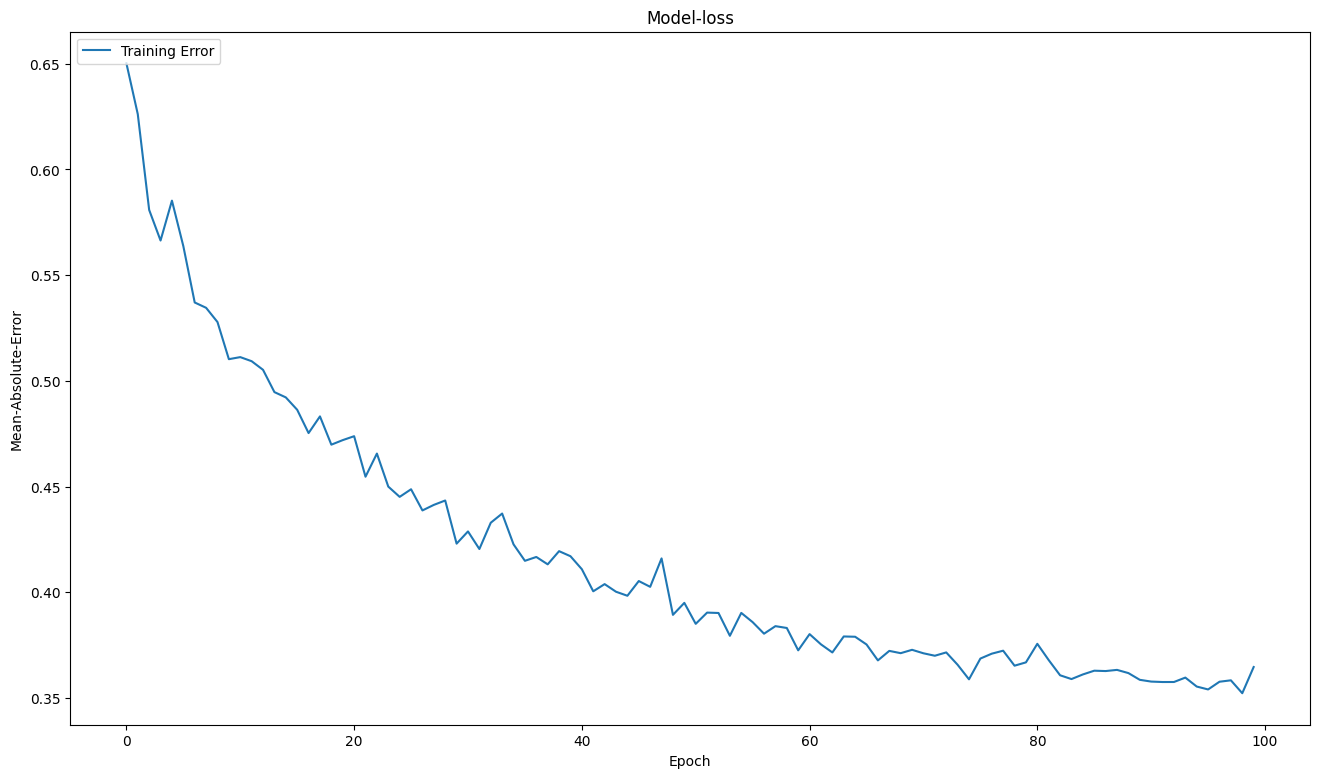

In [125]:
#summarize history for loss
plt.figure(figsize=(16,9))
plt.plot(model.history.history['loss'])
plt.title('Model-loss')
plt.xlabel('Epoch')
plt.ylabel('Mean-Absolute-Error')
plt.legend(['Training Error', 'Testing Error'],loc='upper left')
plt.show()

## Predecting the Target variable for the Test Data

In [126]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled)

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 1ms/step
(3008, 9)


CDP    GTEP     TIT     TAT    AFDP        CO       AT  Actual  \
13312  12.219  25.762  1092.5  550.25  4.0023   1.26430  24.0930  134.46   
12627  10.791  20.085  1059.6  549.94  3.2106   2.69370  20.4500  111.88   
6393   12.126  25.221  1089.9  549.62  4.5325   1.96250  20.2620  133.72   
4990   12.218  25.965  1092.9  549.96  4.4266   1.57120  26.8620  133.79   
12462  10.466  19.688  1056.9  550.01  3.1241   2.29960  19.4090  110.77   
7405   10.624  19.387  1058.9  550.17  3.3709   4.27640   2.2158  113.32   
10993  12.088  25.392  1089.7  550.11  3.7871   0.83578  23.8520  133.77   
9488   11.498  23.225  1079.4  549.60  4.2837   2.01980  12.3950  128.98   
14201  13.971  32.518  1100.1  528.98  5.1559   0.87760  12.3590  159.42   
9757   13.862  32.105  1100.0  530.69  5.9309  10.75000   8.6376  161.86   

        Predicted  
13312  134.513885  
12627  112.422089  
6393   133.914352  
4990   133.755325  
12462  111.071228  
7405   113.411499  
10993  133.633133  
9488   129.070541  
14201  160.374481  
9757   160.939331

## Eventhough it can be clearly seen that the predicted value is very close to actual value let's calculate the Error and Absolute Percentage error for each predict test value of Dependent variable

In [129]:
metric_df = predictions_df.iloc[:,[-2,-1]]
metric_df.head()

Actual   Predicted
13312  134.46  134.513885
12627  111.88  112.422089
6393   133.72  133.914352
4990   133.79  133.755325
12462  110.77  111.071228

In [130]:
Mean_APE = np.mean(abs(metric_df['Actual']-metric_df['Predicted'])/metric_df['Actual'])
print("The Accuarcy of Neural Network model is",100-Mean_APE)

The Accuarcy of Neural Network model is 99.99681633857418


In [132]:
metric_df['Error'] = metric_df['Actual']-metric_df['Predicted']
metric_df['APE'] = (metric_df['Actual']-metric_df['Predicted'])*100/metric_df['Actual'] # Here APE stands for Absolute Percentage Error
metric_df.head()

Actual   Predicted     Error       APE
13312  134.46  134.513885 -0.053885 -0.040075
12627  111.88  112.422089 -0.542089 -0.484527
6393   133.72  133.914352 -0.194352 -0.145343
4990   133.79  133.755325  0.034675  0.025917
12462  110.77  111.071228 -0.301228 -0.271940

## The relation between predicted and actual value can be visualized via the scatter Plot

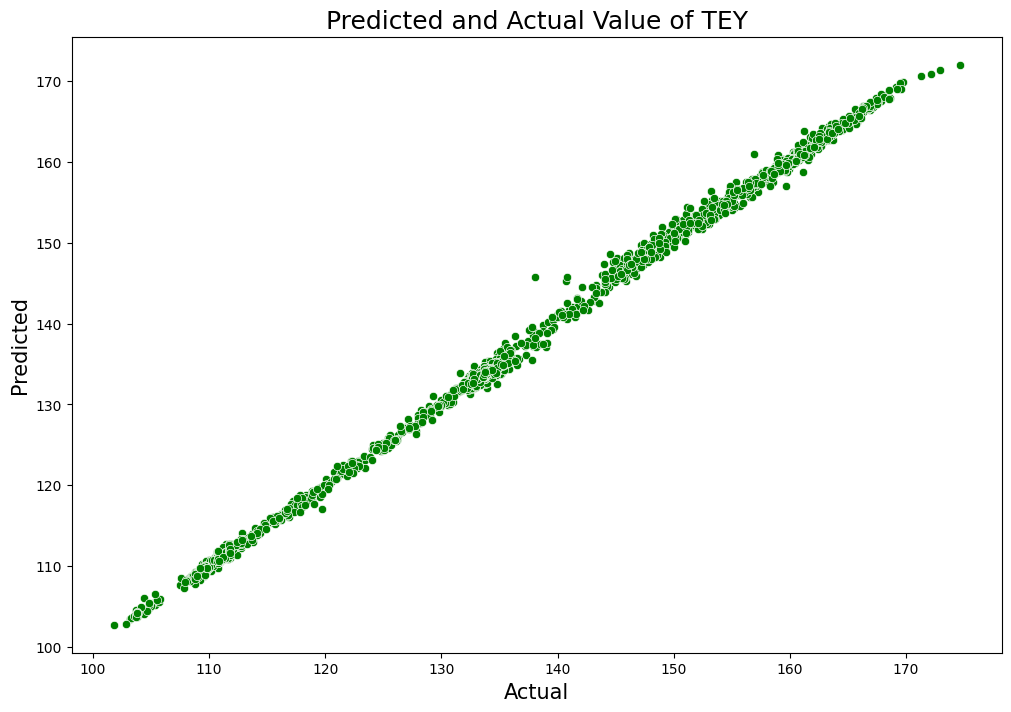

In [136]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=metric_df,x='Actual',y='Predicted',color='g')
plt.xlabel("Actual",fontsize=15)
plt.ylabel("Predicted",fontsize=15)
plt.title("Predicted and Actual Value of TEY",fontsize=18)
plt.show()

In [138]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled)
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))

MAE: 0.43406189390953553
MSE: 0.42267606852063994
RMSE: 0.6501354232163019
376/376 [==============================] - 1s 3ms/step
R2_score (train):  0.9985128133757339
R2_score (test):  0.998311926539262


## Now that we Know Prediction of our model is good let's conclude with Q-Q Plot

<Figure size 1200x800 with 0 Axes>

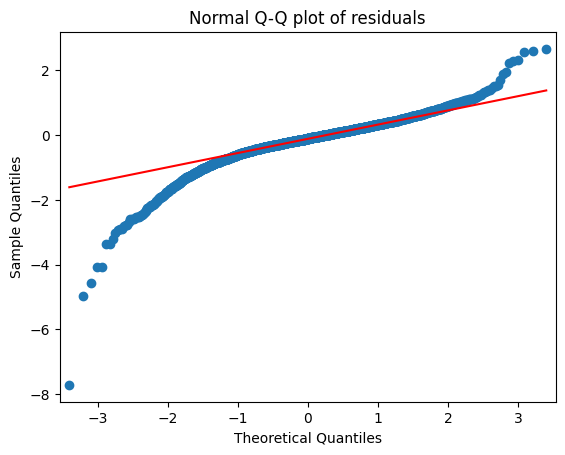

In [140]:
import statsmodels.api as smf
plt.figure(figsize=(12,8))
smf.qqplot(metric_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()